# PySpark Assessment

## Setup Local Environment

### Windows
---
Prerequisites for the following the steps:

    1. Windows OS
    2. miniconda3
        - install only for current User (to avoid system vars)
        - use `include to PATH` during installation
    3. Installation of Java JDK 8
    4. winutils.exe
        - can be found in github
        - moved to sample dir `C:\winutils\bin\winutils.exe`

### Google Colab

In [1]:
from IPython import get_ipython

if "google.colab" in str(get_ipython()):
    import os
    !pip install pyspark
    !pip install -U -q PyDrive
    !apt install openjdk-8-jdk-headless -qq
    !pip install wget

    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
else:
    print("Setup Skipped")

Setup Skipped


In [2]:
if "google.colab" in str(get_ipython()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    get_ipython().system_raw('./ngrok http 4050 &')
    !curl -s http://localhost:4040/api/tunnels | python3 -c \
        "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
else:
    print("Setup Skipped")

Setup Skipped


---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.dataframe import DataFrame
from pyspark import SparkContext, SparkConf

%matplotlib inline

In [4]:
# create session
conf = SparkConf().set("spark.ui.port", "4050").setAppName('zeta')

# create context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

### Fix jupyter whitespace

In [6]:
%%html
<style>
div.output_area pre {
    white-space: pre;
}
</style>

## Download Census Income

#### Input_fn

In [7]:
import os


my_path = "../data/"
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz"

def input_fn(url: str, file_path: str = os.path.abspath('.'), **kwargs):
    f_path = os.path.join(file_path, url.split('/')[-1])
    f_name = '.'.join(f_path.split('.')[:-1])

    if not os.path.isfile(f_name):
        import wget
        import shutil
        import gzip

        wget.download(url)
        with gzip.open(f_path, 'rb') as z:
            with open(f_name, 'wb') as f:
                shutil.copyfileobj(z, f)
    
    return spark.read.csv(f_name, **kwargs)


df = input_fn(url=data_url, file_path=my_path, inferSchema=False)

# trim in case of spaces
for c in df.columns:
    df = df.withColumn(c, trim(col(c)))

df.show(5)

+---+--------------------+---+---+--------------------+---+---------------+-------------+--------------------+--------------------+--------------------+---------+------+---------------+---------------+--------------------+----+----+----+-----------------+---------------+---------------+--------------------+--------------------+-------+----------+-----------+-----------+--------------------+---------------+----+--------------------+-------------+-------------+-------------+--------------------+----+---------------+----+----+----+--------+
|_c0|                 _c1|_c2|_c3|                 _c4|_c5|            _c6|          _c7|                 _c8|                 _c9|                _c10|     _c11|  _c12|           _c13|           _c14|                _c15|_c16|_c17|_c18|             _c19|           _c20|           _c21|                _c22|                _c23|   _c24|      _c25|       _c26|       _c27|                _c28|           _c29|_c30|                _c31|         _c32|       

#### Fix Column Names

In [8]:
# column name url
name_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.names"


def names_fn(url: str, file_path: str = os.path.abspath('.')):
    f_name = os.path.join(file_path, url.split('/')[-1])

    if not os.path.isfile(f_name):
        import wget
        wget.download(url)

    with open(f_name, 'rb') as f:
        return f.readlines()

def names_to_headers(lines: list):
    def mapper(l):
        l = l.decode('utf-8').strip()
        if l and l[0].isalpha():
            return l.split(': ')
        else:
            return None

    lines = map(mapper, lines)
    lines = filter(lambda l: l, lines)
    return list(lines)

In [9]:
info = names_fn(name_url)
head = names_to_headers(info)

# bool +/- 50k missing
head.append(['over 50k', ">50k, <50k"])

print(len(head), sep='\n')

42


In [10]:
def _mapper(x):
    x[0] = x[0].replace(' ', '_')
    x[1] = x[1].strip('.').split(', ')
    return x

def change_headers(dataframe: DataFrame, headers: list):
    for c, (h, _) in zip(df.columns, headers):
        dataframe = dataframe.withColumnRenamed(c, h)
    return dataframe

In [11]:
head = list(map(_mapper, head))
df = change_headers(df, head)
head = {k: v for k, v in head}

df.show(5)

+---+--------------------+------------------------+--------------------------+--------------------+-------------+--------------------------+-------------+--------------------+---------------------+--------------------+---------------+------+-----------------------+-----------------------+---------------------------------+-------------+--------------+---------------------+-----------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+---------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+------------------------------------------+-----------------+--------------------+----+--------+
|age|     class_of_worker|detailed_in

#### Expected Distinct Vals

In [12]:
pd.DataFrame.from_dict(head, orient='index')

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
age,continuous,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
class_of_worker,Not in universe,Federal government,Local government,Never worked,Private,Self-employed-incorporated,Self-employed-not incorporated,State government,Without pay,None,...,None,None,None,None,None,None,None,None,None,None
detailed_industry_recode,0,40,44,2,43,47,48,1,11,19,...,23,26,6,7,9,49,27,8,10,20
detailed_occupation_recode,0,12,31,44,19,32,10,23,26,28,...,6,5,1,11,7,None,None,None,None,None
education,Children,7th and 8th grade,9th grade,10th grade,High school graduate,11th grade,12th grade no diploma,5th or 6th grade,Less than 1st grade,Bachelors degree(BA AB BS),...,None,None,None,None,None,None,None,None,None,None
wage_per_hour,continuous,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
enroll_in_edu_inst_last_wk,Not in universe,High school,College or university,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
marital_stat,Never married,Married-civilian spouse present,Married-spouse absent,Separated,Divorced,Widowed,Married-A F spouse present,None,None,None,...,None,None,None,None,None,None,None,None,None,None
major_industry_code,Not in universe or children,Entertainment,Social services,Agriculture,Education,Public administration,Manufacturing-durable goods,Manufacturing-nondurable goods,Wholesale trade,Retail trade,...,None,None,None,None,None,None,None,None,None,None
major_occupation_code,Not in universe,Professional specialty,Other service,Farming forestry and fishing,Sales,Adm support including clerical,Protective services,Handlers equip cleaners etc,Precision production craft & repair,Technicians and related support,...,None,None,None,None,None,None,None,None,None,None


In [13]:
def val_to_null(dataframe: DataFrame, values: (list, tuple)):
    
    for v in values:
        for c in dataframe.columns:
            dataframe = dataframe.withColumn(c,
                                             when(col(c).contains(v), None)
                                             .otherwise(col(c))
                                             )
    return dataframe

In [14]:
to_null_list = ['Not in universe', '?']
df = val_to_null(df, to_null_list)

df.show(5)

+---+--------------------+------------------------+--------------------------+--------------------+-------------+--------------------------+-------------+-------------------+---------------------+--------------------+---------------+------+-----------------------+-----------------------+---------------------------------+-------------+--------------+---------------------+-----------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+---------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+------------------------------------------+-----------------+--------------------+----+--------+
|age|     class_of_worker|detailed_ind

> *NOTE*
>
> sometimes `'not in universe'` indicates different behavioural patterns than `null`;
but these attributes don't seem to, given the semantics of the dataset

### Schema & Summary
#### Change to Nominal Vals and Numeric Types wherever is needed

df includes both nominal and numerical values.

In [15]:
# numeric columns
numeric = filter(lambda kv: len(kv[1]) == 1, head.items())
numeric = list(map(lambda kv: kv[0], numeric))

# nominal columns
nominal = list(filter(lambda c: c not in numeric, df.columns))

In [16]:
# nominals with a mean are already numeric e.g. industry code or year
# however, we can still use the indexer
df.select(*nominal).summary("mean").show()

+-------+---------------+------------------------+--------------------------+---------+--------------------------+------------+-------------------+---------------------+----+---------------+----+-----------------------+-----------------------+---------------------------------+--------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-----------------------+-----------------------+-----------------------+---------------------+-----------+-----------------------------+------------------------------------------+------------------+-----------------+--------+
|summary|class_of_worker|detailed_industry_recode|detailed_occupation_recode|education|enroll_in_edu_inst_last_wk|marital_stat|major_industry_code|major_occupation_code|race|hispanic_origin| sex|member

#### Change Numeric Types

In [17]:
types = ('tinyint', 'smallint', 'smallint', 'smallint', 'smallint', 'double', 'tinyint', 'tinyint')


def numeric_fn(dataframe: DataFrame, cols: list, new_types: list, alt_type: (str, type) = ''):
    for c, t in zip(cols, new_types):
        if alt_type:
            new = 'int' if 'int' in t else t
            alt = 'int' if 'int' in alt_type else alt_type

            val = df.toPandas()[c].unique()
            if any(np.not_equal(val.astype(new), val.astype(alt))):
                t = alt_type

        dataframe = dataframe.withColumn(c, col(c).cast(t))
    return dataframe

#### Numeric Columns' Schema

In [18]:
df = numeric_fn(df, cols=numeric, new_types=types, alt_type='double')

df.select(*numeric).printSchema()

root
 |-- age: byte (nullable = true)
 |-- wage_per_hour: short (nullable = true)
 |-- capital_gains: short (nullable = true)
 |-- capital_losses: short (nullable = true)
 |-- dividends_from_stocks: short (nullable = true)
 |-- instance_weight: double (nullable = true)
 |-- num_persons_worked_for_employer: byte (nullable = true)
 |-- weeks_worked_in_year: byte (nullable = true)



#### Change Nominals

In [19]:
from pyspark.ml.feature import StringIndexer
from typing import List


new_nom = list(map(lambda c: c + "_idx", nominal))


def nominal_fn(dataframe: DataFrame, cols: list, new_cols: list):
    idx = StringIndexer(inputCols=cols, outputCols=new_cols, handleInvalid="keep")
    return idx.fit(dataframe).transform(dataframe)


def idx_values(dataframe: DataFrame, column: str):
    """
    IndexToString is much slower than collecting
    index metas
    """
    for f in dataframe.schema.fields:
        if f.name == column:
            vals = f.metadata['ml_attr']['vals']
            mx = dataframe.select(column).summary("max").collect()[0][1]
            # remove __unknown if needed
            if len(vals) > float(mx) + 1:
                vals.pop(-1)
                
            return vals
        

# it is possible to change types and save space, but afterwards it will be
# impossible to get back the strings through IndexToString function
def nominal_type_fn(dataframe: DataFrame, cols: list, check_bool: bool = False):
    if check_bool:
        distinct = dataframe.select(*cols).toPandas().nunique().values
    else:
        distinct = np.empty_like(shape=[len(cols)], prototype=0)

    for dst, c in zip(distinct, cols):
        if dst == 2:
            dataframe = dataframe.withColumn(c, col(c).cast('boolean'))
        else:
            dataframe = dataframe.withColumn(c, col(c).cast('tinyint'))

    return dataframe

#### Nominal Columns' Schema

In [20]:
from pyspark.sql.utils import IllegalArgumentException


try:
    df = nominal_fn(df, cols=nominal, new_cols=new_nom)
except IllegalArgumentException:
    print('output column already exists')

# df = nominal_type_fn(df, cols=new_nom, check_bool=False)

df.select(*new_nom).printSchema()

root
 |-- class_of_worker_idx: double (nullable = false)
 |-- detailed_industry_recode_idx: double (nullable = false)
 |-- detailed_occupation_recode_idx: double (nullable = false)
 |-- education_idx: double (nullable = false)
 |-- enroll_in_edu_inst_last_wk_idx: double (nullable = false)
 |-- marital_stat_idx: double (nullable = false)
 |-- major_industry_code_idx: double (nullable = false)
 |-- major_occupation_code_idx: double (nullable = false)
 |-- race_idx: double (nullable = false)
 |-- hispanic_origin_idx: double (nullable = false)
 |-- sex_idx: double (nullable = false)
 |-- member_of_a_labor_union_idx: double (nullable = false)
 |-- reason_for_unemployment_idx: double (nullable = false)
 |-- full_or_part_time_employment_stat_idx: double (nullable = false)
 |-- tax_filer_stat_idx: double (nullable = false)
 |-- region_of_previous_residence_idx: double (nullable = false)
 |-- state_of_previous_residence_idx: double (nullable = false)
 |-- detailed_household_and_family_stat_idx:

#### Remove Duplicates

In [21]:
from typing import Any


def duplicate_fn(dataframe: DataFrame, subset: Any = None):
    init = dataframe.count()
    dataframe = dataframe.dropDuplicates(subset=subset)

    print(f'{init - dataframe.count()} duplicates were removed from a total of {init} entries')

    return dataframe

In [22]:
df = duplicate_fn(df.select(*numeric, *new_nom), None)

3229 duplicates were removed from a total of 199523 entries


#### Dataframe Summary, Total Rows & Columns

In [23]:
print(f"TOTAL ENTRIES: {df.count()}",
      f"TOTAL COLUMNS: {len(df.columns)}",
      sep='\t')

df.summary().show()

TOTAL ENTRIES: 196294	TOTAL COLUMNS: 42
+-------+-----------------+-----------------+------------------+-----------------+---------------------+------------------+-------------------------------+--------------------+-------------------+----------------------------+------------------------------+------------------+------------------------------+------------------+-----------------------+-------------------------+------------------+-------------------+------------------+---------------------------+---------------------------+-------------------------------------+------------------+--------------------------------+-------------------------------+--------------------------------------+-------------------------------------------+--------------------------------+--------------------------------+----------------------------------+---------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+-------------

### Aggregate Table with Distinct Values

In [24]:
dist_fn = lambda columns: (countDistinct(c).alias(c) for c in columns)

df.agg(*dist_fn(df.columns)).show()

+---+-------------+-------------+--------------+---------------------+---------------+-------------------------------+--------------------+-------------------+----------------------------+------------------------------+-------------+------------------------------+----------------+-----------------------+-------------------------+--------+-------------------+-------+---------------------------+---------------------------+-------------------------------------+------------------+--------------------------------+-------------------------------+--------------------------------------+-------------------------------------------+--------------------------------+--------------------------------+----------------------------------+---------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+-------------------------+---------------+---------------------------------+------------------------------------------

### Explanatory analysis
*note: dataset should have been cleaned more carefully before (eg `9999` vals in wage/hr)*

#### Count NAs

In [25]:
perc = df.count()

for c in df.columns:
    if c in numeric:
        counter = df.filter(col(c).isNull()).count()
    else:
        vals = idx_values(df, c)
        if vals[-1] == "__unknown":
            counter = df.select(c).where(col(c) == len(vals)-1).count()
        else:
            continue
    
    print(counter, "({:.1f}%)".format(100*counter/perc), f" Nulls @ {c}", sep="\t")

0	(0.0%)	 Nulls @ age
0	(0.0%)	 Nulls @ wage_per_hour
403	(0.2%)	 Nulls @ capital_gains
0	(0.0%)	 Nulls @ capital_losses
127	(0.1%)	 Nulls @ dividends_from_stocks
0	(0.0%)	 Nulls @ instance_weight
0	(0.0%)	 Nulls @ num_persons_worked_for_employer
0	(0.0%)	 Nulls @ weeks_worked_in_year
97029	(49.4%)	 Nulls @ class_of_worker_idx
183762	(93.6%)	 Nulls @ enroll_in_edu_inst_last_wk_idx
97467	(49.7%)	 Nulls @ major_industry_code_idx
97467	(49.7%)	 Nulls @ major_occupation_code_idx
177232	(90.3%)	 Nulls @ member_of_a_labor_union_idx
190226	(96.9%)	 Nulls @ reason_for_unemployment_idx
180562	(92.0%)	 Nulls @ region_of_previous_residence_idx
181269	(92.3%)	 Nulls @ state_of_previous_residence_idx
99434	(50.7%)	 Nulls @ migration_code-change_in_msa_idx
99434	(50.7%)	 Nulls @ migration_code-change_in_reg_idx
99434	(50.7%)	 Nulls @ migration_code-move_within_reg_idx
99434	(50.7%)	 Nulls @ live_in_this_house_1_year_ago_idx
180562	(92.0%)	 Nulls @ migration_prev_res_in_sunbelt_idx
144161	(73.4%)	 Nu

---
***It is clear that there are several nominal values with minimal explanatory power due to the total amount of unknown values. (This concept is discussed under the assumption that we are discussing about data analysis and machine learning methodologies, where quanbtity comes over quality)***

***Also, the difference in null values between numeric and nominal columns is suspicious***

In [26]:
df.filter(col("age") == 0).count()

2643

***Some numeric columns include 0 as Null***

In [27]:
for c in numeric:
    counter = df.filter(col(c) == 0).count() + df.filter(col(c).isNull()).count()
    print(counter, "({:.1f}%)".format(100*counter/perc), f" Zeros & Nulls @ {c}", sep="\t")

2643	(1.3%)	 Zeros & Nulls @ age
184991	(94.2%)	 Zeros & Nulls @ wage_per_hour
189318	(96.4%)	 Zeros & Nulls @ capital_gains
192388	(98.0%)	 Zeros & Nulls @ capital_losses
175283	(89.3%)	 Zeros & Nulls @ dividends_from_stocks
0	(0.0%)	 Zeros & Nulls @ instance_weight
92770	(47.3%)	 Zeros & Nulls @ num_persons_worked_for_employer
92770	(47.3%)	 Zeros & Nulls @ weeks_worked_in_year


***check Zeros & Nulls over 50k***

In [29]:
target = "over_50k_idx"

temp = df.filter(col(target) == 1)
temp = temp.select(*numeric)
perc = temp.count()

for c in temp.columns:
    counter = temp.filter(col(c) == 0).count() + temp.filter(col(c).isNull()).count()
    print(counter, "({:.1f}%)".format(100*counter/perc), f" Zeros & Nulls @ {c}", sep="\t")

0	(0.0%)	 Zeros & Nulls @ age
11826	(95.5%)	 Zeros & Nulls @ wage_per_hour
10314	(83.3%)	 Zeros & Nulls @ capital_gains
11213	(90.6%)	 Zeros & Nulls @ capital_losses
7192	(58.1%)	 Zeros & Nulls @ dividends_from_stocks
0	(0.0%)	 Zeros & Nulls @ instance_weight
596	(4.8%)	 Zeros & Nulls @ num_persons_worked_for_employer
596	(4.8%)	 Zeros & Nulls @ weeks_worked_in_year


---
***Depending the distribution of nulls in respect with our response variable, some might be useful in some special cases; but in general, most of them do not hold enough explanatory power to describe our dataset in respect with its initial purpose, which is the prediction of income (`over_50k_idx`). However, `dividends` seems to be an exception.***

#### Save and Drop Columns with Nulls > 90%
*note: helps with total cpu/memory usage*

In [30]:
to_drop = [
    "enroll_in_edu_inst_last_wk_idx", "member_of_a_labor_union_idx", "reason_for_unemployment_idx",
    "region_of_previous_residence_idx", "state_of_previous_residence_idx", "migration_prev_res_in_sunbelt_idx", 
    "fill_inc_questionnaire_for_veteran's_admin_idx", "wage_per_hour", "capital_gains", "capital_losses"
]

if 'alt_df' not in locals():
    alt_df = df.select(*to_drop, "over_50k_idx")
    df = df.drop(*to_drop)
    
    nominal = [c for c in df.columns if "idx" in c]  # new categorical
    numeric = [c for c in df.columns if "idx" not in c]  # new numeric
    

print(f"total {len(alt_df.columns)} columns were dropped out of {len(df.columns)+len(alt_df.columns)}")

total 11 columns were dropped out of 43


In [31]:
my_col = "over_50k_idx"

_count = df.select(my_col).filter(col(my_col) == 1).count()

print(f"TOTAL >50k: {_count}",
      f"TOTAL <50k: {df.count() - _count}",
      sep="\n")

TOTAL >50k: 12382
TOTAL <50k: 183912


In [32]:
df.summary().show()

+-------+-----------------+---------------------+------------------+-------------------------------+--------------------+-------------------+----------------------------+------------------------------+------------------+------------------+-----------------------+-------------------------+------------------+-------------------+------------------+-------------------------------------+------------------+--------------------------------------+-------------------------------------------+--------------------------------+--------------------------------+----------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+-------------------------+------------------+---------------------------------+---------------------+-------------------+-------------------+
|summary|              age|dividends_from_stocks|   instance_weight|num_persons_worked_for_employer|weeks_worked_in_year|class_of_worker_idx|detailed_in

In [33]:
def pandas_scatter(dataframe: DataFrame, **plot_kwargs):
    pdf = dataframe.toPandas()
    axs = pd.plotting.scatter_matrix(pdf, **plot_kwargs)
    num = len(pdf.columns)

    for i in range(num):
        vertical = axs[i, 0]
        vertical.yaxis.label.set_rotation(0)
        vertical.yaxis.label.set_ha("right")

        horizontal = axs[num-1, i]
        horizontal.xaxis.label.set_rotation(75)

        vertical.set_yticks([])
        horizontal.set_xticks([])

#### KDE: Density Functions & Cross correlation

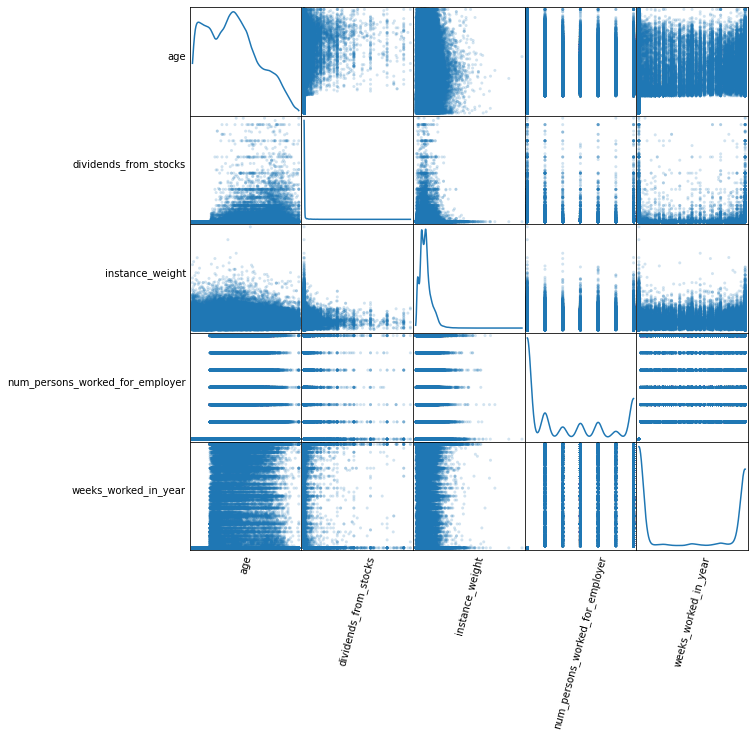

In [34]:
pandas_scatter(df.select(*numeric), alpha=.2, figsize=(10, 10), diagonal='kde')

---
- Age: It probably follow a bimodal distribution; it skews due to the legal working age
- Instance weight: it probably follows a gamma distribution; we need to examine the outliers.
- Persons/employer: it probably follows a uniform distribution; however, it can also be treated as ordinal variable
- Weeks/year: We need to check the outliers if they are reasonable.

Total Vals >7.5k:  0.1%


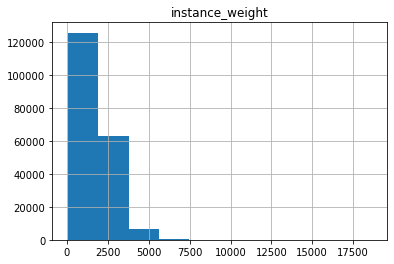

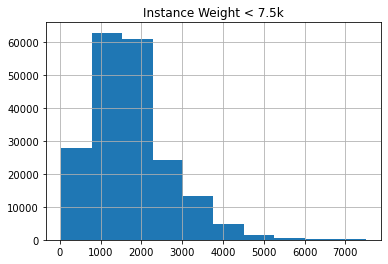

In [35]:
my_col = "instance_weight"

df.select(my_col).toPandas().hist()

temp = df.select(col(my_col).alias("Instance Weight <7.5k")).filter(col(my_col) < 7500)
temp.toPandas().hist()
print("Total Vals >7.5k: ", "{:.1f}%".format(100*(df.count()-temp.count())/df.count()))

plt.show()

`Instance Weight` seems to follow approx a chi square distribution and the rest are outlier or errors

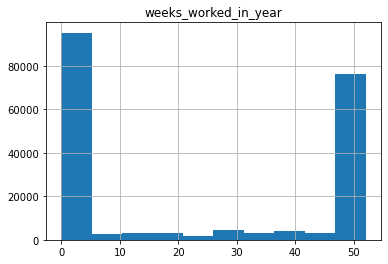

In [36]:
my_col = "weeks_worked_in_year"

df.select(my_col).toPandas().hist()
plt.show()

`weeks_worked_in_year` values are reasonably either ~0 or ~52. We can transform this variable to categorical to be more meaningful.

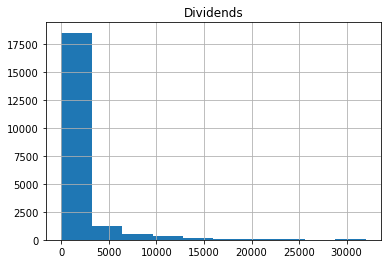

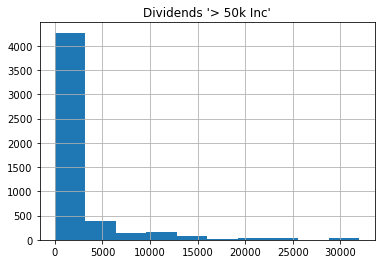

In [59]:
my_col = "dividends_from_stocks"
temp = df.select(my_col, target).filter(col(target) == 1)

for t, dd in zip(["Dividends", "Dividends '> 50k Inc'"], [df, temp]):
    dd.select(col(my_col).alias(t)).filter(col(my_col) > 0).toPandas().hist()

***As expected, dividends show to follow an exponential distribution***

---
#### Nominal Columns

***Several Columns with similar information also seem to have similar null percentage. We need to check their correlation and determine the amount the information we get from these variables. While this can be achieved with chi-square or spearman's tests, we are going to use graphs to save time.***

#### Migration Indices excluding Nulls

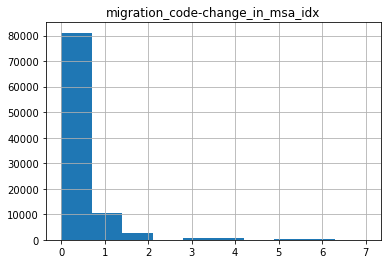

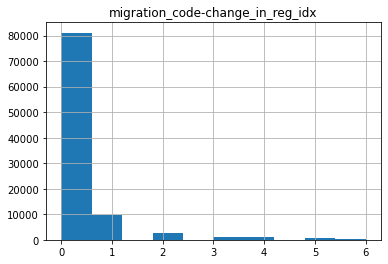

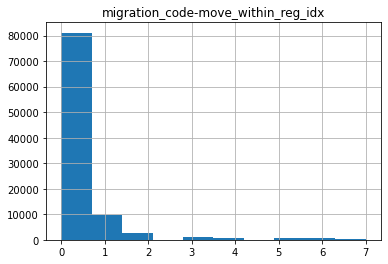

In [37]:
my_col = ['migration_code-change_in_msa_idx', 'migration_code-change_in_reg_idx', 'migration_code-move_within_reg_idx']

for i, c in enumerate(my_col):
    df.select(c).filter(col(c) < len(idx_values(df, c))-1).toPandas().hist()

***As expected there's really high correlation between migration.***

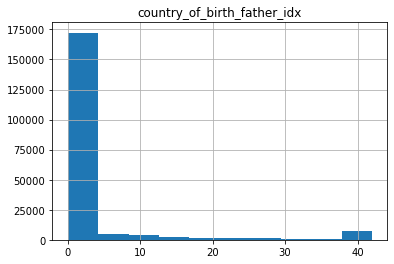

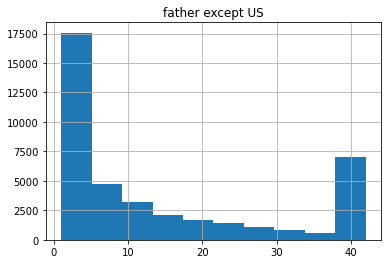

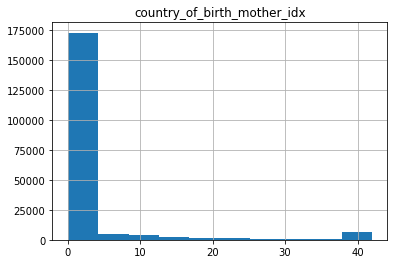

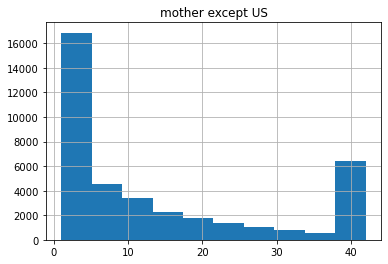

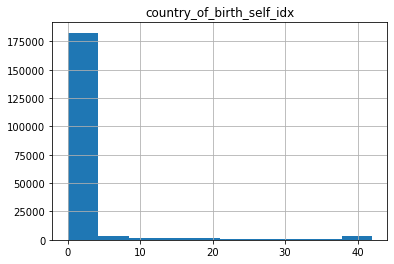

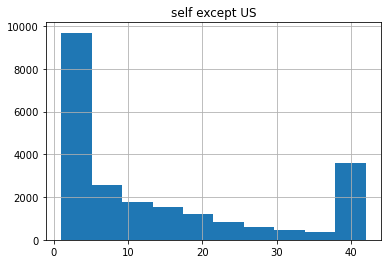

In [38]:
my_col = ['country_of_birth_father_idx', 'country_of_birth_mother_idx', 'country_of_birth_self_idx']


for i, c in enumerate(my_col):
    df.select(c).toPandas().hist()
    df.select(col(c).alias(c.split("_")[-2] + " except US")).filter(col(c) > 0).toPandas().hist()

***Again there's really high correlation & US born workers naturally overwhelm the dataset;***

#### Code

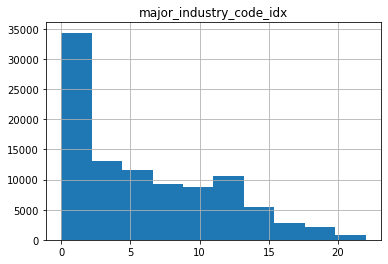

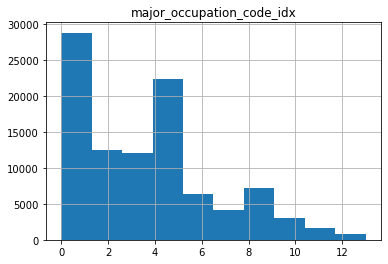

In [39]:
my_col = ["major_industry_code_idx", "major_occupation_code_idx"]

for i, c in enumerate(my_col):
    df.select(c).filter(col(c) < len(idx_values(df, c))-1).toPandas().hist()

***These columns are correlated and (along with others) they could be subjects to variable reduction methodologies***

#### Other interesting Attributes

In [42]:
df.select(*nominal).summary().show()

+-------+-------------------+----------------------------+------------------------------+------------------+------------------+-----------------------+-------------------------+------------------+-------------------+------------------+-------------------------------------+------------------+--------------------------------------+-------------------------------------------+--------------------------------+--------------------------------+----------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+-------------------------+------------------+---------------------------------+---------------------+-------------------+-------------------+
|summary|class_of_worker_idx|detailed_industry_recode_idx|detailed_occupation_recode_idx|     education_idx|  marital_stat_idx|major_industry_code_idx|major_occupation_code_idx|          race_idx|hispanic_origin_idx|           sex_idx|full_or_part_time_employment_

In [43]:
series = df.select('class_of_worker_idx').toPandas().value_counts(normalize=True).sort_index()
series = pd.DataFrame(series, columns=['percent'])
series.assign(attributes = idx_values(df, "class_of_worker_idx"))

,percent,attributes
class_of_worker_idx,,
0.0,0.366904,Private
1.0,0.043007,Self-employed-not incorporated
2.0,0.039650,Local government
3.0,0.021534,State government
4.0,0.016628,Self-employed-incorporated
5.0,0.014901,Federal government
6.0,0.002231,Never worked
7.0,0.000841,Without pay
8.0,0.494304,__unknown


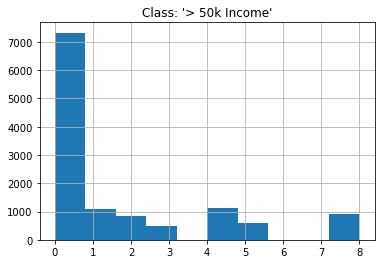

In [44]:
my_col = 'class_of_worker_idx'
target = 'over_50k_idx'
temp = df.select(my_col, target).filter(col(target) == 1)
temp.select(col(my_col).alias("Class: '> 50k Income'")).toPandas().hist()
plt.show()

***It's interesting that worker's class nulls are unevenly distributed between over and under 50k***

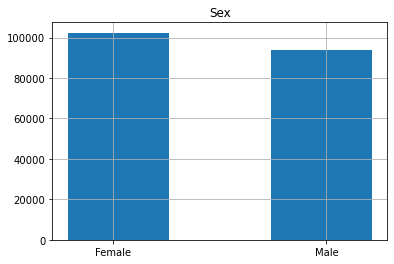

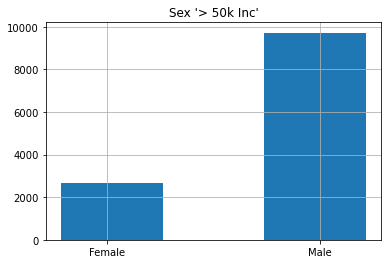

In [45]:
my_col = "sex_idx"
temp = df.select(my_col, target).filter(col(target) == 1)

for t, dd in zip(["Sex", "Sex '> 50k Inc'"], [df, temp]):
    dd.select(col(my_col).alias(t)).toPandas().hist(bins=3)
    plt.xticks([0.15, 0.85], idx_values(df, my_col))

### Select Features

***We have already dropped several features which included nulls over 90%. Furthermore, features like Country of Birth and Migration Codes are highly correlated and there is no reason to use more than one. Finally, there are other features which should be abandoned (even if their explanatory power is high), because they are semantically irrelevant with income.***

#### PCA to Reduce similar Features before we start

In [134]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.regression import GeneralizedLinearRegression


def feature_creator(dataframe: DataFrame, columns: list, target: str, names: list = ['features', 'label']):
    dataframe = dataframe.drop(names[0])
    if names[0] in columns:
        columns.remove(names[0])

    assembler = VectorAssembler(inputCols=columns, outputCol=names[0])
    dataframe = assembler.transform(dataframe)
    
    return dataframe.withColumnRenamed(target, names[1])



def pca_select(dataframe: DataFrame, k: int = 2, names: list = ['features', 'pcaFeatures'], drop_columns: list = []):
    pca = PCA(k=2, inputCol=names[0], outputCol=names[1])
    pca = pca.fit(dataframe).transform(dataframe)
    return pca.drop(*drop_columns) if drop_columns else pca


def glr_selector(dataframe: DataFrame, features: int, sample_size: float = 1.0, sample_iter: int = 1):
    pvals = np.zeros(shape=(1, features))
    for _ in range(sample_iter):
        sample = dataframe.sample(False, sample_size)
        glr = GeneralizedLinearRegression(family="binomial", link="logit", maxIter=10, regParam=0.0)
        model = glr.fit(sample)
        pvals += np.array(model.summary.pValues[1:])
            

In [135]:
my_col = ['migration_code-change_in_msa_idx', 'migration_code-change_in_reg_idx', 'migration_code-move_within_reg_idx']

data = feature_creator(df, my_col, target)
# data = pca_select(data, k=2, drop_columns=my_col)

data.show(5)

+---+---------------------+---------------+-------------------------------+--------------------+-------------------+----------------------------+------------------------------+-------------+----------------+-----------------------+-------------------------+--------+-------------------+-------+-------------------------------------+------------------+--------------------------------------+-------------------------------------------+--------------------------------+--------------------------------+----------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+-------------------------+---------------+---------------------------------+---------------------+--------+-----+-------------+
|age|dividends_from_stocks|instance_weight|num_persons_worked_for_employer|weeks_worked_in_year|class_of_worker_idx|detailed_industry_recode_idx|detailed_occupation_recode_idx|education_idx|marital_stat_idx|major_indust

In [136]:
data = feature_creator(data, data.columns, 'label')


In [96]:
my_col = ['country_of_birth_father_idx', 'country_of_birth_mother_idx', 'country_of_birth_self_idx']


In [97]:
my_col = ["major_industry_code_idx", "major_occupation_code_idx"]


In [98]:
my_col = df.columns[:-1]
remove = ['country_of_birth_father_idx', 'country_of_birth_mother_idx', 'migration_code-change_in_reg_idx',
 'migration_code-move_within_reg_idx', 'year_idx']
for i in remove:
    my_col.remove(i)

In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

data = feature_creator(df, df.columns, target)
glr = GeneralizedLinearRegression(family="binomial", link="logit", maxIter=10, 
regParam=0.0)
data = data.select('features', 'label')

model = glr.fit(data)
model.summary

In [181]:
# from pyspark.sql import Row
# from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(
    inputCols=my_col,
    outputCol='features')

trainingData = assembler.transform(df)
trainingData = trainingData.withColumnRenamed("over_50k_idx", "label")
# trainingData = trainingData.select('features', 'label')
trainingData.show(5)

+---+---------------------+---------------+-------------------------------+--------------------+-------------------+----------------------------+------------------------------+-------------+----------------+-----------------------+-------------------------+--------+-------------------+-------+-------------------------------------+------------------+--------------------------------------+-------------------------------------------+--------------------------------+--------------------------------+----------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+-------------------------+---------------+---------------------------------+---------------------+--------+-----+-------------+
|age|dividends_from_stocks|instance_weight|num_persons_worked_for_employer|weeks_worked_in_year|class_of_worker_idx|detailed_industry_recode_idx|detailed_occupation_recode_idx|education_idx|marital_stat_idx|major_indust

In [184]:
my_col

['migration_code-change_in_msa_idx',
 'migration_code-change_in_reg_idx',
 'migration_code-move_within_reg_idx']

In [182]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="binomial", link="logit", maxIter=10, 
regParam=0.0)

model = glr.fit(trainingData)
# print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
# print("T Values: " + str(summary.tValues))
# print("P Values: " + str(summary.pValues))

In [183]:
summary = model.summary
summary.pValues

[0.05848836751077435, 0.14341015342993257, 0.00418795806858463, 0.0]

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(trainingData)
result = model.transform(trainingData).select("label", "pcaFeatures")
result.show(truncate=False)

In [ ]:
try2 = result.withColumnRenamed("pcaFeatures", "features")

glr = GeneralizedLinearRegression(family="binomial", link="logit", maxIter=10, 
regParam=0.0)

model = glr.fit(try2)

model.summary